In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,ReLU
from keras.models import load_model

from xgboost import  XGBClassifier
from sklearn.metrics import roc_auc_score,confusion_matrix,f1_score,accuracy_score, recall_score,classification_report,get_scorer_names
from sklearn.metrics import roc_curve, precision_recall_curve,plot_roc_curve



In [246]:
df=pd.read_csv('afterEDA.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [247]:
#y is our target variable and X are independent features
y=df['Exited']
X=df.drop('Exited',axis=1)
print(y.shape)
print(X.shape)

(10000,)
(10000, 10)


In [248]:
y.value_counts(normalize=True)
#our class is imbalanced but it can work 

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In [249]:
cat_cols= list(df.select_dtypes('object').columns)
print(cat_cols)
X= pd.get_dummies(X, columns=cat_cols, drop_first=True)
X.head(3)

['Geography', 'Gender']


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0


In [250]:
# Spliting data into train and test sets, for imblanced data use stratified sampling because there 
# is a risk of ending up with almost no cases of minority class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=45,stratify=df.Exited)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8000, 11) (8000,)
(2000, 11) (2000,)


In [251]:
from imblearn.over_sampling import SMOTE 
smote= SMOTE(random_state=42)
X_train, y_train= smote.fit_resample(X_train, y_train)
print(y_train.value_counts(normalize=True))
#now class is balanced

0    0.5
1    0.5
Name: Exited, dtype: float64


In [252]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [222]:
#building model
model = Sequential([ 
Dense(units=10,activation='relu',input_dim=11), 
Dense(units=5,activation='relu'),
Dense(units=1,activation='sigmoid')
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 10)                120       
                                                                 
 dense_34 (Dense)            (None, 5)                 55        
                                                                 
 dense_35 (Dense)            (None, 1)                 6         
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [223]:
model.compile(optimizer = 'Adam',loss='binary_crossentropy',metrics=['accuracy'])

early stopping is method to stop epoch when model performance stops improving on hold out validation dataset in neural network

In [225]:
es = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=20, verbose=2, mode='auto', baseline=None, restore_best_weights=False)

history = model.fit(X_train,y_train,validation_split=0.2,epochs=200,callbacks=es)

#loss: traning loss, should be decreasing order
#accuracy: trainig accuracy, shoulb be in increasing order
#val_loss: validation loss, should be decreasing and close to training loss
#val_accuracy: validation accuracy, should be increasing order and close to training accuracy

Epoch 1/200
319/319 [==============================] - 1s 2ms/step - loss: 0.3901 - accuracy: 0.8298 - val_loss: 0.4249 - val_accuracy: 0.7979
Epoch 2/200
319/319 [==============================] - 1s 2ms/step - loss: 0.3895 - accuracy: 0.8312 - val_loss: 0.4141 - val_accuracy: 0.8002
Epoch 3/200
319/319 [==============================] - 1s 2ms/step - loss: 0.3888 - accuracy: 0.8300 - val_loss: 0.4127 - val_accuracy: 0.8034
Epoch 4/200
319/319 [==============================] - 1s 2ms/step - loss: 0.3890 - accuracy: 0.8300 - val_loss: 0.4519 - val_accuracy: 0.7806
Epoch 5/200
319/319 [==============================] - 0s 1ms/step - loss: 0.3886 - accuracy: 0.8303 - val_loss: 0.4095 - val_accuracy: 0.8010
Epoch 6/200
319/319 [==============================] - 0s 1ms/step - loss: 0.3882 - accuracy: 0.8308 - val_loss: 0.3773 - val_accuracy: 0.8187
Epoch 7/200
319/319 [==============================] - 1s 2ms/step - loss: 0.3882 - accuracy: 0.8302 - val_loss: 0.3992 - val_accuracy: 0.8081

In [226]:
ytrain_log = model.predict(X_train)
ytrain_pred = np.where(ytrain_log>0.5,1,0) # this means if y_log > 0.5 then 1 else 0

def error_metrics(actual, predicted, X_data):
    print('Accuracy % age: ' + str(np.round(accuracy_score(actual, predicted)*100, 2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, model.predict(X_data)),3)))
    print('\nClassification Report:')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(actual, predicted))
    return "Done"

error_metrics(y_train,ytrain_pred,X_train)

399/399 [==============================] - 0s 808us/step
Accuracy % age: 82.48
399/399 [==============================] - 0s 1ms/step
ROC-AUC Score: 0.911

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      6370
           1       0.89      0.75      0.81      6370

    accuracy                           0.82     12740
   macro avg       0.83      0.82      0.82     12740
weighted avg       0.83      0.82      0.82     12740


Confusion Matrix:
[[5756  614]
 [1618 4752]]


'Done'

In [227]:
ytest_log = model.predict(X_test)
ytest_pred = np.where(ytest_log>0.5,1,0)
accuracy_score(y_test,ytest_pred)

error_metrics(y_test,ytest_pred,X_test)

63/63 [==============================] - 0s 887us/step
Accuracy % age: 83.15
63/63 [==============================] - 0s 865us/step
ROC-AUC Score: 0.832

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1593
           1       0.58      0.59      0.59       407

    accuracy                           0.83      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.83      0.83      0.83      2000


Confusion Matrix:
[[1421  172]
 [ 165  242]]


'Done'

Train accuacy is 82.48 and test accuracy is 83.15 close to each other, that's decent accuracy


Xgboost Model

In [259]:
xgb_weighted = XGBClassifier(verbosity = 0, random_state = 3)

grid_list = {'nthread':[4], 'objective':['binary:logistic'], 'learning_rate': [0.001,0.006, 0.01, 0.03,0.04],
             'max_depth': [2,4,5], 'min_child_weight': [2,3,4], 'silent': [1],
             'subsample': [0.7], 'colsample_bytree': [0.7], 'n_estimators': [100]}

# initializing the gridsearch and finding optimum set of hyperparameters. Error metric used is roc_auc score.
# Training the gridsearch and finding the best model.
xgb_grid_search = GridSearchCV(estimator = xgb_weighted, param_grid = grid_list, cv = 5, n_jobs = 4, 
                               verbose = 1, scoring = 'f1')
xgb_grid_search.fit(X_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_
xgb_best_model

Fitting 5 folds for each of 45 candidates, totalling 225 fits


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.04, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=3, reg_alpha=0, ...)


Training
------------------------------------------------------------
Accuracy % age: 84.75
ROC-AUC Score: 0.926

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      6370
           1       0.85      0.84      0.85      6370

    accuracy                           0.85     12740
   macro avg       0.85      0.85      0.85     12740
weighted avg       0.85      0.85      0.85     12740


Confusion Matrix:
[[5439  931]
 [1012 5358]]

 ROC-AUC Curve for the training set


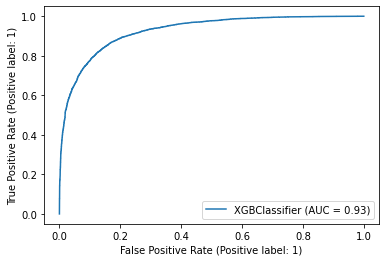

In [260]:
def error_metrics(actual, predicted, X_data):
    print('Accuracy % age: ' + str(np.round(accuracy_score(actual, predicted)*100, 2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, xgb_best_model.predict_proba(X_data)[:,1]),3)))
    print('\nClassification Report:')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(actual, predicted))
    return "Done"

print("\nTraining\n------------------------------------------------------------")
y_train_pred = xgb_best_model.predict(X_train)
error_metrics(y_train, y_train_pred, X_train)

print("\n ROC-AUC Curve for the training set")
plot_roc_curve(xgb_best_model, X_train, y_train)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 80.8
ROC-AUC Score: 0.844

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1593
           1       0.52      0.69      0.59       407

    accuracy                           0.81      2000
   macro avg       0.72      0.76      0.73      2000
weighted avg       0.83      0.81      0.82      2000


Confusion Matrix:
[[1336  257]
 [ 127  280]]

 ROC-AUC Curve for the testing set


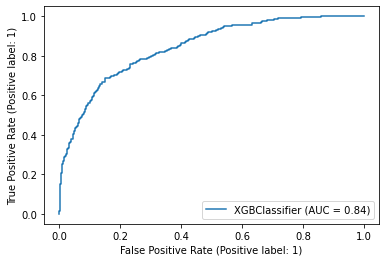

In [261]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_pred = xgb_best_model.predict(X_test)
error_metrics(y_test, y_test_pred, X_test)

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(xgb_best_model, X_test, y_test)
plt.show()